Optimal Solution: 010101111000010 - 30.0
Initial Gamma: [0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152 0.79172504 0.52889492
 0.56804456 0.92559664 0.07103606]
Initial Beta: [0.0871293  0.0202184  0.83261985 0.77815675 0.87001215 0.97861834
 0.79915856 0.46147936 0.78052918 0.11827443 0.63992102 0.14335329
 0.94466892 0.52184832 0.41466194]
Initial Objective: 19.16040627599355

Time to optimize: 275.2454659938812 seconds

Final Gamma: [ 0.35731514  0.68618921  0.75690094  0.60554446  0.4556197   1.00831555
 -0.13021164  0.94332961  0.98393697 -0.06397921  0.94467693  1.0468646
  0.05051995  0.78855215  0.35593361]
Final Beta: [0.56149758 0.45393784 0.35384096 1.77177514 0.28119666 1.15287242
 0.79584583 0.25304652 1.27069092 0.54180582 0.1715548  0.28708084
 1.42346219 0.00317032 0.08662759]
Final Objective: 29.29477645187002

010101111000010 (30) - 0.31441680377506126
101010000111101 (30) - 0.31441680377506126

Expectati

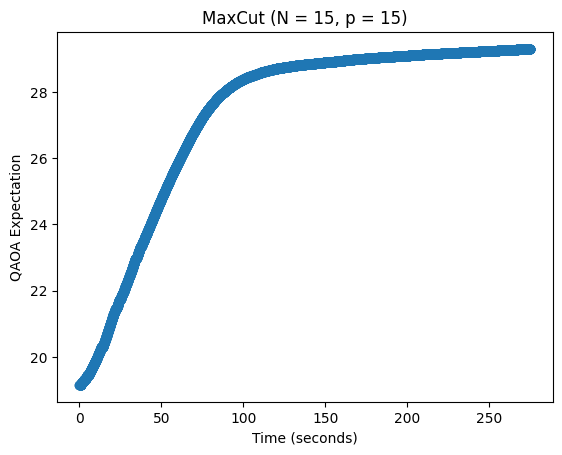

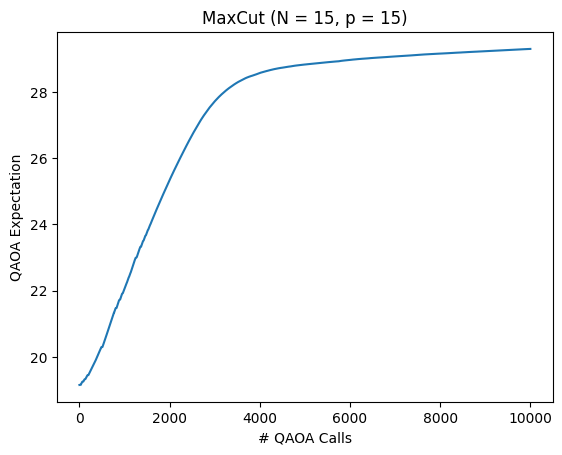

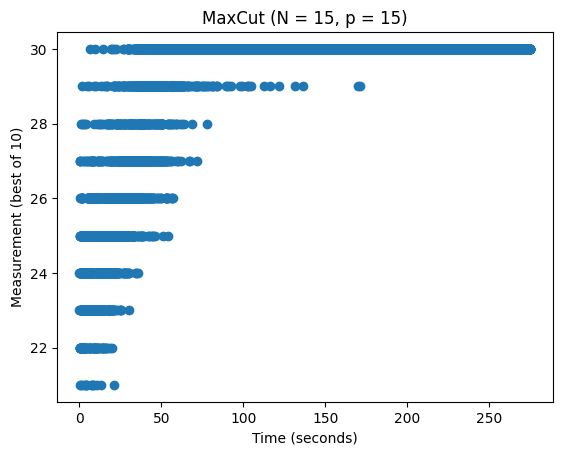

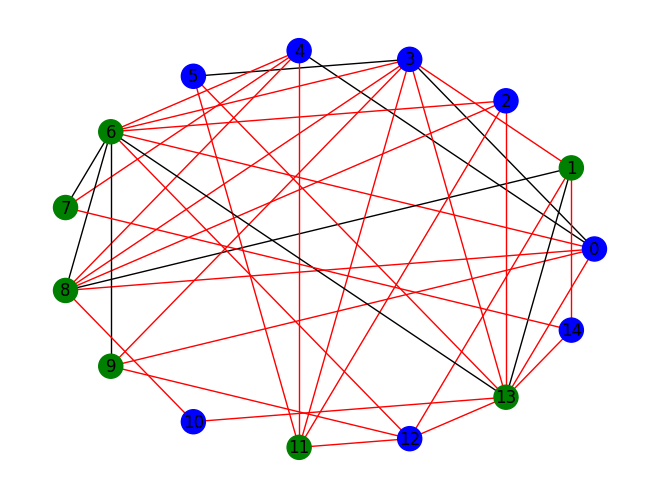

In [6]:
import typing
import qokit
import numpy as np
import scipy
import networkx as nx
import time
from matplotlib import pyplot as plt
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType
import qokit.maxcut as mc


def compute_graph_colors(G: nx.Graph, solution_index: int) -> tuple[list[str], list[str]]:
    N = G.number_of_nodes()
    vert_colors = list(map(lambda c: "green" if c == "1" else "blue", f"{int(solution_index):0{N}b}"))
    vert_colors.reverse()
    edge_colors = [("red" if vert_colors[u] != vert_colors[v] else "black") for u, v in G.edges()]
    return (vert_colors, edge_colors)


def print_result(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, adjective: str = "") -> None:
    p = len(gamma)
    print(f"{adjective}Gamma: {gamma}")
    print(f"{adjective}Beta: {beta}")
    print(f"{adjective}Objective: {-inv_max_cut_objective(N, p, terms)(np.hstack([gamma, beta]))}")
    print()


def evaluate_cut(G: nx.Graph, bool_verts: list[bool]) -> int:
    cuts = 0
    for u, v in G.edges():
        if bool_verts[u] != bool_verts[v]:
            cuts += 1
    return cuts


def print_probabilities(
    G: nx.Graph, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, threshold: float = 0, only_likely: bool = False, include_cost: bool = True
) -> None:
    N = G.number_of_nodes()
    probs = get_probabilities(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), probs)):
        [index, prob] = element
        likely_str = ""
        if prob > threshold:
            likely_str = " <- Likely outcome"

        cost_str = ""
        if include_cost:
            contained_verts = list(map(lambda c: c == "1", f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        if not only_likely:
            print(f"{int(index):0{N}b}{cost_str} - {prob}{likely_str}")
        else:
            if prob > threshold:
                print(f"{int(index):0{N}b}{cost_str} - {prob}")


def print_state_vector(G: nx.Graph, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, include_cost: bool = True) -> None:
    N = G.number_of_nodes()
    sv = get_state_vector(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), sv)):
        [index, amplitude] = element
        cost_str = ""
        if include_cost:
            contained_verts = list(map(lambda c: c == "1", f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        print(f"{int(index):0{N}b}{cost_str} - {amplitude}")


def plot_expectation(expectations: list[float], N: int, p: int, start_time: float) -> None:
    def make_time_relative(input: tuple[float, float]) -> tuple[float, float]:
        time, expectation = input
        return (time - start_time, expectation)

    time_relative_expectations = list(map(make_time_relative, expectations))
    plt.scatter(*zip(*time_relative_expectations))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("QAOA Expectation")
    plt.show()


def plot_measurements(measurements: list[float], N: int, p: int, start_time: float) -> None:
    def make_time_relative(input: tuple[float, float]) -> tuple[float, float]:
        time, measurement = input
        return (time - start_time, measurement)

    time_relative_measurements = list(map(make_time_relative, measurements))
    plt.scatter(*zip(*time_relative_measurements))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Measurement (best of 10)")
    plt.show()

def plot_expectation_vs_QAOA_calls(expectations: list[float], N: int, p: int) -> None:
    plt.plot([entry[1] for entry in expectations])
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("# QAOA Calls")
    plt.ylabel("QAOA Expectation")
    plt.show()



def optimal_solution_with_index(sim: QAOAFastSimulatorBase) -> tuple[float, int]:
    costs = sim.get_cost_diagonal()
    solution = max(costs)
    solution_index = np.where(costs == solution)[0][0]
    return (solution, solution_index)


def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none


def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result


def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)


def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)


def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)


def get_state_vector(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray) -> np.ndarray:
    simclass = qokit.fur.choose_simulator(name="auto")
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_statevector(_result)


# Evaluates the objective function, and if expectations or measurements is passed in, appends to them
def inv_max_cut_objective(
    N: int, p: int, terms: TermsType, expectations: list[float] | None = None, measurements: list[float] | None = None, sim: QAOAFastSimulatorBase | None = None
) -> typing.Callable:
    def f(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        current_time = time.time()
        simulator = get_simulator(N, terms, sim)
        probs = get_probabilities(N, terms, gamma, beta, sim)
        costs = simulator.get_cost_diagonal()
        expectation = np.dot(costs, probs)

        if expectations != None:
            expectations.append((current_time, expectation))

        if measurements != None:
            measurement = max(np.random.choice(costs, 10, p=probs))
            measurements.append((current_time, measurement))

        return -expectation

    return f


# Given Eising terms and initial parameters, runs scipy.optimize.minimize and returns optimized parameters
# If expectations or measurements is passed in, populates them (this harms runtime)
def optimize(
    N: int,
    terms: TermsType,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    expectations: list[float] | None = None,
    measurements: list[float] | None = None,
    sim: QAOAFastSimulatorBase | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    if expectations != None:
        expectations.clear()
    if measurements != None:
        measurements.clear()

    p = len(init_gamma)
    assert len(init_beta) == p, "Gamma and Beta must have the same length"
    init_freq = np.hstack([init_gamma, init_beta])

    res = scipy.optimize.minimize(inv_max_cut_objective(N, p, terms, expectations, measurements, sim), init_freq, method="COBYLA", options={"rhobeg": 0.01 / N, "maxiter": 1e4})

    gamma, beta = res.x[:p], res.x[p:]
    return (gamma, beta)


# Generates a random graph with N vertices and runs MaxCut QAOA on this graph, plotting results
def run_experiment(seed: int, N: int, p: int) -> None:
    np.random.seed(seed)
    G = nx.erdos_renyi_graph(N, 0.5, seed=seed)  # Random graph w/ 0.5 edge probability
    terms = mc.get_maxcut_terms(G)
    sim = get_simulator(N, terms)
    expectations = []
    measurements = []

    # Compute and print solution by brute force
    solution, solution_index = optimal_solution_with_index(sim)
    print(f"Optimal Solution: {solution_index:0{N}b} - {solution}")
    vert_colors, edge_colors = compute_graph_colors(G, solution_index)

    # Random starting parameters
    init_gamma, init_beta = np.random.rand(2, p)
    print_result(N, terms, init_gamma, init_beta, "Initial ")

    start_time = time.time()
    # If you don't want expectation and measurement plots, do not pass in parameters!
    gamma, beta = optimize(N, terms, init_gamma, init_beta, expectations, measurements, sim)
    end_time = time.time()
    print(f"Time to optimize: {end_time - start_time} seconds\n")

    print_result(N, terms, gamma, beta, "Final ")
    print_probabilities(G, terms, gamma, beta, threshold=0.5 / N, only_likely=True)
    print()
    print("Expectations:\n", expectations)
    plot_expectation(expectations, N, p, start_time)
    plot_expectation_vs_QAOA_calls(expectations, N, p)
    plot_measurements(measurements, N, p, start_time)

    nx.draw(G, nx.circular_layout(G), node_color=vert_colors, edge_color=edge_colors, with_labels=True)


run_experiment(seed=0, N=15, p=15)

In [1]:
from QAOA_simulator import QAOA_run, get_simulator
from plot_utils import plot_wireframe, plot_3d_scatter, plot_color_projection
import networkx as nx
import qokit.maxcut as mc
import matplotlib.pyplot as plt
import numpy as np
import pickle # For saving files
from datetime import datetime


# for creating a responsive plot (requires you to run `pip install ipympl` in your venv)
%matplotlib widget 

max_data = 20
max_N = max_data
max_p = max_data
data_N = np.linspace(1, max_N, max_N)
data_p = np.linspace(1, max_p, max_p)
data_time = np.zeros([max_N, max_p])
data_expectation = np.zeros([max_N, max_p])
data_overlap = np.zeros([max_N, max_p])
data_num_calls = np.zeros([max_N, max_p])

graphs = [nx.erdos_renyi_graph(N, 0.5) for N in range(1, max_N + 1)]
optimizer_options = {"maxiter" : 100_000}

save_results_pickle = True

for N, p in np.ndindex((max_N, max_p)):
  for p in range(0,max_p+1):
    # Get the current date and time
    now = datetime.now()
    date_and_time = now.strftime("%Y_%m_%d_%H_%M")
    print(f"Starting QAOA with N={N}, p={p} at date/time " + date_and_time)
    output_filename = f"DataSaves/QAOA_N={N}_p={p}_" + date_and_time + ".pkl"

    G = graphs[N-1]
    ising_model = mc.get_maxcut_terms(G)
    init_gamma, init_beta = np.random.rand(2, p)
    result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA", optimizer_options=optimizer_options)
    data_time[N][p] = result["runtime"]
    data_expectation[N][p] = result["expectation"]
    data_overlap[N][p] = result["overlap"]
    data_num_calls[N][p] = result["num_QAOA_calls"]

    # Save results in a pickle file
    if save_results_pickle:
      with open(output_filename, 'wb') as outp:
        pickle.dump(result, outp, pickle.HIGHEST_PROTOCOL)


Starting QAOA with N=19, p=0 at date/time 2024_07_08_14_15


/home/spencer/qokit/lib64/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/spencer/qokit/lib64/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Starting QAOA with N=19, p=1 at date/time 2024_07_08_14_15
Starting QAOA with N=19, p=2 at date/time 2024_07_08_14_15
Starting QAOA with N=19, p=3 at date/time 2024_07_08_14_15
Starting QAOA with N=19, p=4 at date/time 2024_07_08_14_16
Starting QAOA with N=19, p=5 at date/time 2024_07_08_14_17
Starting QAOA with N=19, p=6 at date/time 2024_07_08_14_20
Starting QAOA with N=19, p=7 at date/time 2024_07_08_14_20
Starting QAOA with N=19, p=8 at date/time 2024_07_08_14_29
Starting QAOA with N=19, p=9 at date/time 2024_07_08_14_32
Starting QAOA with N=19, p=10 at date/time 2024_07_08_14_49
Starting QAOA with N=19, p=11 at date/time 2024_07_08_14_54
Starting QAOA with N=19, p=12 at date/time 2024_07_08_15_24
Starting QAOA with N=19, p=13 at date/time 2024_07_08_15_38
Starting QAOA with N=19, p=14 at date/time 2024_07_08_16_01
Starting QAOA with N=19, p=15 at date/time 2024_07_08_16_28
Starting QAOA with N=19, p=16 at date/time 2024_07_08_17_11
Starting QAOA with N=19, p=17 at date/time 2024_0

IndexError: index 20 is out of bounds for axis 0 with size 20

In [1]:

plot_wireframe(data_N, data_p, data_time, title = "Runtime grows exponentially :(", xlabel = "N (number of vertices)", ylabel = "p (circuit depth)", zlabel = "Runtime (seconds)")
plot_3d_scatter(data_N, data_p, data_time, title = "Runtime grows exponentially :(", xlabel = "N (number of vertices)", ylabel = "p (circuit depth)", zlabel = "Runtime (seconds)")
plot_3d_scatter(data_N[4:], data_p[1:], data_overlap[4:].T[1:].T, title = "Success is hard :'(", xlabel = "N (number of vertices)", ylabel = "p (circuit depth)", zlabel = "Success Probability")
plot_3d_scatter(data_N, data_p, data_num_calls, title = "QAOA calls vs N,p", xlabel = "N (number of vertices)", ylabel = "p (circuit depth)", zlabel = "Number of QAOA calls")
plot_color_projection(data_N, data_p, data_time, title = "Runtime grows exponentially :(", xlabel = "N (number of vertices)", zlabel = "Runtime (seconds)")
plot_color_projection(data_p, data_N, data_time.T, title = "Runtime grows linearly in p", xlabel = "p (circuit depth)", zlabel = "Runtime (seconds)")
plot_color_projection(data_p, data_N, data_expectation.T, title = "Increasing circuit depth helps Expectation a little :)", xlabel = "p (circuit depth)", zlabel = "Expectation")
plot_color_projection(data_p, data_N[4:], data_overlap[4:].T, title = "Increasing circuit depth doesn't help Overlap :O", xlabel = "p (circuit depth)", zlabel = "Overlap")

plt.show()

NameError: name 'plot_wireframe' is not defined

In [ ]:
from QAOA_simulator import get_expectation, get_overlap, get_simulator, get_result
from plot_utils import plot_heat_map
import networkx as nx
import qokit.maxcut as mc
import numpy as np
import matplotlib.pyplot as plt


def collect_parameter_data(G: nx.Graph, gammas: np.ndarray, betas: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    expectations = np.zeros([len(gammas), len(betas)])
    overlaps = np.zeros([len(gammas), len(betas)])
    N = G.number_of_nodes()
    ising_model = mc.get_maxcut_terms(G)
    sim = get_simulator(N, ising_model)

    for i in range(len(gammas)):
        for j in range(len(betas)):
            gamma = np.array([gammas[i]])
            beta = np.array([betas[j]])
            result = get_result(N, ising_model, gamma, beta, sim)
            expectations[i][j] = get_expectation(N, ising_model, gamma, beta, sim, result)
            overlaps[i][j] = get_overlap(N, ising_model, gamma, beta, sim, result)

    return (expectations, overlaps)


N = 10
G = nx.erdos_renyi_graph(N, 0.5)
gammas = np.linspace(-np.pi, np.pi, 100)
betas = np.linspace(-2 * np.pi, 2 * np.pi, 100)
expectations, overlaps = collect_parameter_data(G, gammas, betas)
plot_heat_map(gammas, betas, expectations, "Expectation", "Gamma", "Beta")
plot_heat_map(gammas, betas, overlaps, "Success Probability", "Gamma", "Beta")

plt.show()